# Unconditional and conditional density estimation

Normalizing flows are generative models that utilize multiple parameterized transformations to create expressive probabilty density functions which can be evaluated exactly. In this notebook, we demonstrate unconditional and conditional normalizing flow training on the two moons data set.

Interactive online version:

<a href="https://colab.research.google.com/github/dirmeier/surjectors/blob/main/docs/notebooks/normalizing_flows.ipynb">
    <img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg" style="vertical-align:text-bottom">
</a>

In [1]:
import distrax
import haiku as hk
import jax
import numpy as np
import optax

%matplotlib inline
from collections import namedtuple

import matplotlib.pyplot as plt
import seaborn as sns
from jax import jit
from jax import numpy as jnp
from jax import random as jr
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from surjectors import (
    Chain,
    MaskedAutoregressive,
    MaskedCoupling,
    Permutation,
    TransformedDistribution,
)
from surjectors.nn import MADE, make_mlp
from surjectors.util import (
    as_batch_iterator,
    make_alternating_binary_mask,
    unstack,
)

We define a training function first that we can use for all density estimation tasks below.

In [2]:
def train(rng_key, data, model, n_iter=1000):
    # convert the data set to an iterator
    batch_key, rng_key = jr.split(rng_key)
    train_iter = as_batch_iterator(batch_key, data, 100, True)

    # initialize the model
    init_key, rng_key = jr.split(rng_key)
    params = model.init(init_key, method="log_prob", **train_iter(0))

    # create an optimizer
    optimizer = optax.adam(1e-4)
    state = optimizer.init(params)

    @jit
    # gradient step
    def step(params, state, **batch):
        def loss_fn(params):
            lp = model.apply(params, None, method="log_prob", **batch)
            return -jnp.mean(lp)

        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, new_state = optimizer.update(grads, state, params)
        new_params = optax.apply_updates(params, updates)
        return loss, new_params, new_state

    losses = np.zeros(n_iter)
    # training loop
    for i in tqdm(range(n_iter)):
        train_loss = 0.0
        # iterate over batches
        for j in range(train_iter.num_batches):
            batch = train_iter(j)
            batch_loss, params, state = step(params, state, **batch)
            train_loss += batch_loss
        losses[i] = train_loss

    return params, losses

## Unconditional normalizing flows

Let's illustrate using an masked autoregressive bijector for unconditional density estimation on the two moons data. A sample is shown below.

In [3]:
n = 10000
y, _ = datasets.make_moons(n_samples=n, noise=0.05)
y = StandardScaler(with_std=False).fit_transform(y)

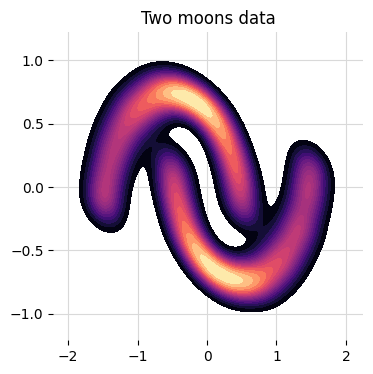

In [4]:
_, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(
    x=y[:, 0], y=y[:, 1], cmap="magma", fill=True, levels=20, zorder=2, ax=ax
)
for side in ["top", "right", "left", "bottom"]:
    ax.spines[side].set_visible(False)
ax.grid(axis="both", color="0.85", zorder=1)
ax.set_title("Two moons data")
plt.show()

We define a flow that consists of five layers of masked autoregressive flows (MAFs). Each flow takes a conditioner and an inner bijector function. The conditioner for MAFs is a MADE network for which we can use the `MADE` class.
The inner bijector can be anything, for instance, an RQ-NSF or an affine transformation.

In [5]:
def make_flow(n_dimensions):
    def flow(**kwargs):
        def bijector_fn(params):
            means, log_scales = unstack(params, -1)
            return distrax.Inverse(
                distrax.ScalarAffine(means, jnp.exp(log_scales))
            )

        layers = []
        order = jnp.arange(n_dimensions)
        for i in range(5):
            layer = MaskedAutoregressive(
                conditioner=MADE(n_dimensions, [128, 128], 2),
                bijector_fn=bijector_fn,
            )
            order = order[::-1]
            layers.append(layer)
            layers.append(Permutation(order, 1))

        transform = Chain(layers)
        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(n_dimensions), jnp.ones(n_dimensions)),
            reinterpreted_batch_ndims=1,
        )
        pushforward = TransformedDistribution(base_distribution, transform)

        return pushforward(**kwargs)

    td = hk.transform(flow)
    return td

This defines the entire flow. We can now train it and sample some data from the trained model.

In [6]:
rng_key_seq = hk.PRNGSequence(0)
fn = make_flow(2)
data = namedtuple("named_dataset", "y")(y)
params, losses = train(next(rng_key_seq), data, fn)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.27it/s]


In [7]:
samples = fn.apply(
    params, next(rng_key_seq), method="sample", sample_shape=(10000,)
)

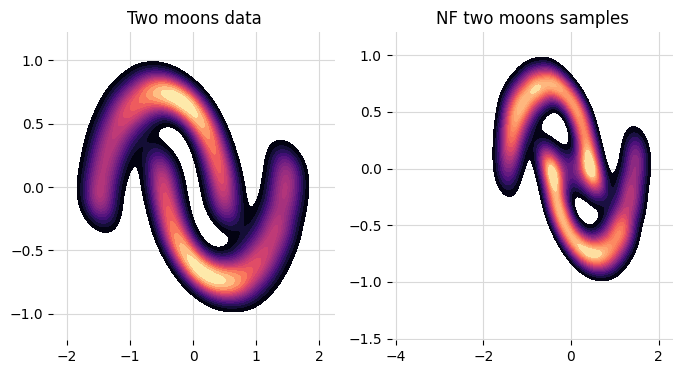

In [8]:
_, axes = plt.subplots(figsize=(8, 4), ncols=2)
ax = sns.kdeplot(
    x=y[:, 0],
    y=y[:, 1],
    cmap="magma",
    fill=True,
    levels=20,
    zorder=2,
    ax=axes[0],
)
ax = sns.kdeplot(
    x=samples[:, 0],
    y=samples[:, 1],
    cmap="magma",
    fill=True,
    levels=20,
    zorder=2,
    ax=axes[1],
)
for ax, title in zip(axes, ["Two moons data", "NF two moons samples"]):
    ax.set_title(title)
    ax.grid(axis="both", color="0.85", zorder=1)
    for side in ["top", "right", "left", "bottom"]:
        ax.spines[side].set_visible(False)
plt.show()

## Conditional normalizing flows

We can use the two moons data set for conditional density estimation using the generated labels as conditioning variables. A conditional flow example is shown below. This time we use a masked coupling flow.

In [9]:
n = 10000
y, labels = datasets.make_moons(n_samples=n, noise=0.05)
y = StandardScaler(with_std=False).fit_transform(y)

In [10]:
np.unique(labels)

array([0, 1])

The downward looking moon is labelled with 0 and the upward looking moon with 1.

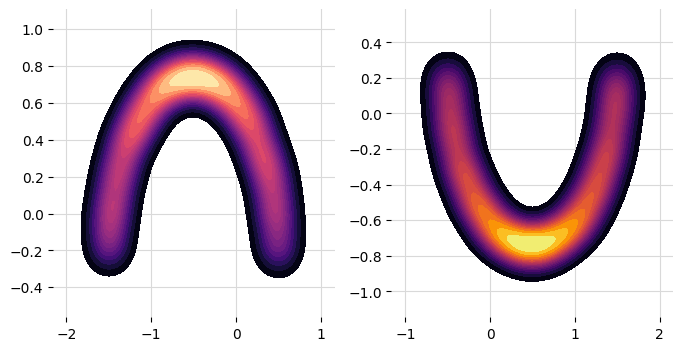

In [11]:
_, axes = plt.subplots(figsize=(8, 4), ncols=2)
ax = sns.kdeplot(
    x=y[labels == 0, 0],
    y=y[labels == 0, 1],
    cmap="magma",
    fill=True,
    levels=20,
    zorder=2,
    ax=axes[0],
)
ax = sns.kdeplot(
    x=y[labels == 1, 0],
    y=y[labels == 1, 1],
    cmap="inferno",
    fill=True,
    levels=20,
    zorder=2,
    ax=axes[1],
)
for ax in axes:
    ax.grid(axis="both", color="0.85", zorder=1)
    for side in ["top", "right", "left", "bottom"]:
        ax.spines[side].set_visible(False)
ax.grid(axis="both", color="0.85", zorder=1)
plt.show()

The definition of conditional flow is *exactly the same* as in the unconditional case. For a bit of variety, we use a masked coupling flow though. One advantage of the coupling flow is that we don't need to have a specific conditioner, but
any MLP will do. One disadvantage is that it is generally a bit less flexible.

In [12]:
def make_flow(n_dimensions):
    def flow(**kwargs):
        def bijector_fn(params):
            means, log_scales = jnp.split(params, 2, -1)
            return distrax.Inverse(
                distrax.ScalarAffine(means, jnp.exp(log_scales))
            )

        layers = []
        for i in range(5):
            layer = MaskedCoupling(
                mask=make_alternating_binary_mask(n_dimensions, i % 2 == 0),
                conditioner=make_mlp([128, 128, 2 * n_dimensions]),
                bijector=bijector_fn,
            )
            layers.append(layer)

        transform = Chain(layers)
        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(n_dimensions), jnp.ones(n_dimensions)),
            reinterpreted_batch_ndims=1,
        )
        pushforward = TransformedDistribution(base_distribution, transform)

        return pushforward(**kwargs)

    td = hk.transform(flow)
    return td

When training a conditional model, the provided **data set needs to contain the conditioning variable** (duh!). Conditioning variables always need to be labelled *x* while modelled variables are always labeled *y*. Apart from this, there
is no distinction between training an unconditional and a conditional model if we use the training function from above.

In [13]:
rng_key_seq = hk.PRNGSequence(0)
fn = make_flow(2)
data = namedtuple("named_dataset", "y x")(y, labels.reshape(-1, 1))
params, losses = train(next(rng_key_seq), data, fn)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.48it/s]


Let's sample only data for which the label is 1, i.e., the upward looking moon of the two moons data set.

In [14]:
samples = fn.apply(
    params, next(rng_key_seq), method="sample", x=jnp.ones((10000, 1))
)

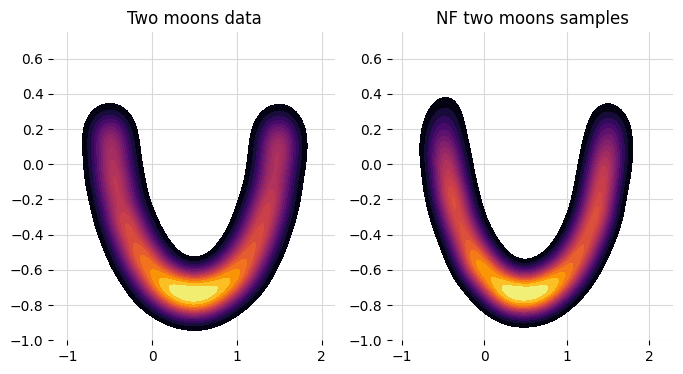

In [15]:
_, axes = plt.subplots(figsize=(8, 4), ncols=2)
ax = sns.kdeplot(
    x=y[labels == 1, 0],
    y=y[labels == 1, 1],
    cmap="inferno",
    fill=True,
    levels=20,
    zorder=2,
    ax=axes[0],
)
ax = sns.kdeplot(
    x=samples[:, 0],
    y=samples[:, 1],
    cmap="inferno",
    fill=True,
    levels=20,
    zorder=2,
    ax=axes[1],
)
for ax, title in zip(axes, ["Two moons data", "NF two moons samples"]):
    ax.set_title(title)
    ax.grid(axis="both", color="0.85", zorder=1)
    for side in ["top", "right", "left", "bottom"]:
        ax.spines[side].set_visible(False)
    ax.set_ylim(-1.0, 0.75)
plt.show()

## Session info

In [17]:
import session_info

session_info.show(html=False)

-----
distrax             0.1.4
haiku               0.0.10
jax                 0.4.18
jaxlib              0.4.18
matplotlib          3.6.3
numpy               1.25.2
optax               0.1.7
seaborn             0.12.2
session_info        1.0.0
sklearn             1.2.1
surjectors          0.3.0
tqdm                4.64.1
-----
IPython             8.12.0
jupyter_client      8.2.0
jupyter_core        5.3.0
jupyterlab          3.6.3
notebook            6.5.4
-----
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2023-10-14 19:35


## References

[1] Dinh, Laurent, et al. "Density estimation using RealNVP". International Conference on Learning Representations, 2017.

[2] Papamakarios, George, et al. "Masked Autoregressive Flow for Density Estimation". Advances in Neural Information Processing Systems, 2017.